# **Distributed computing on the cloud**

In this practice, we are going to have a first contact with pySpark and the cloud.
For this, what we are going to analyze is a dataset obtained by single-cell RNA sequencing, in fastq format.
Since it is a first contact, the objective will be something simple borrowed from this [link](https://towardsdatascience.com/next-generation-sequencing-data-analysis-with-pyspark-888a1e0a079), and you can complicate it as much as you want if you like. In this case, we would simply like to count how many times each base (A,C,G,T) appears in all the sequences obtained.

The first part we will do it directly in a python notebook using pySpark, for example, using Google Colab.
As we will see, the last part takes some time to be executed, so it would be great to move it to the cloud and be able to horizontally scale so we can speed up that last step. For the latter, we'll go to Azure and adapt the code created here to work in the cloud.


If you want to know much more about distributed computing on the cloud, this link is great to start delving into the topic and you can start playing in the Azure cloud:

https://docs.microsoft.com/en-us/learn/paths/cmu-cloud-computing-distributed-programming/

## **1. First, let's learn how to work with pySpark**


... and to do this, here, we need to install pySpark first (we'll see later that this first step will not be necessary in Azure Portal)...

In [ ]:
# Installing pySpark and importing some useful packages
!pip install pyspark[sql]

from __future__ import print_function
from functools import wraps
import pyspark as spark
from pyspark import SparkConf
import time
from operator import add
import os 
from subprocess import STDOUT, check_call, check_output

... and download the data we are going to use...

In [ ]:
!pip install gdown
import gdown
url = 'https://drive.google.com/uc?id=1wDx0J9LXkTUEG-eG3T4zmEoBAbPljYJ6'
output = 'ERR3014700.fastq'
gdown.download(url, output, quiet=False)

Once we have the data, the first thing to do is to 

**INITIALIZE SPARK**, 

connecting to a cluster and configuring it (as we will see later, in Azure we will have a graphical environment to connect to a cluster and configure it).

To do this, Spark has two important functions:


* SparkContext, which tells Spark how to access a cluster.
* SparkConf, which allows us to configure the properties of the Spark application we are creating. To see all these properties, see [this link](https://spark.apache.org/docs/latest/configuration.html). To understand some of these properties, it is also important to know the main components of a cluster, summarized in the following figure and explained in [this link](https://spark.apache.org/docs/latest/cluster-overview.html).

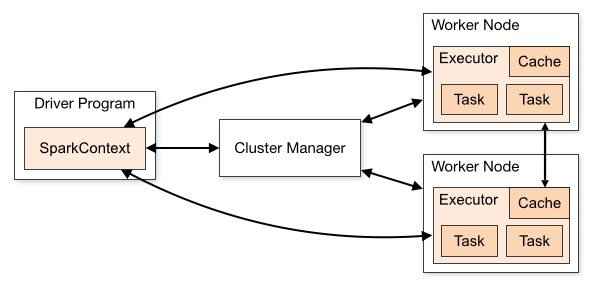

In [ ]:
# Do you dare to comment on each line? I think it is a very good practice and that your coworkers will appreciate it in the future.
def set_conf():
    conf = SparkConf().setAppName("App")
    conf = (conf.setMaster('local[*]')
      .set('spark.executor.memory', '4G')
      .set('spark.driver.memory', '16G')
      .set('spark.driver.maxResultSize', '8G'))
    return conf

In [ ]:
sc = spark.SparkContext.getOrCreate(conf=set_conf())

Perfect! Once we have Spark started and configured, we are ready to

**LOAD THE DATA**.

In [ ]:
data = sc.textFile("ERR3014700.fastq")
# When we have a defined list, we can also distribute it for parallel processing directly. If we do not indicate the number of partitions, Spark will calculate it according to the cluster we are connected to.
#data = sc.parallelize(your_list)

And what we have now is what is known as a


---

**RDD (Resilient Distributed Dataset)**

---

or, as Spark defines it, a collection of fault-tolerant elements that can be executed in parallel.

RDDs support two types of operations:

* Transformations, which create a new dataset from an existing one.
* Actions, which return a value to the main program or driver after executing a computation on the data set.

To see and understand what some of the most used commands in pySpark do, it would be great if you could take a look at [this link](https://nbviewer.jupyter.org/github/jkthompson/pyspark-pictures/blob/master/pyspark-pictures.ipynb).

Do you recognize the transformations and actions in the following examples? Feel free to comment what each example does in the code.

In [ ]:
# lets take a look at the first read... each read in fastq is represented by 4 lines 
data.take(12)

In [ ]:
data.count()

In [ ]:
sequences = data.filter(lambda x: x.isalpha())
sequences.count()

In [ ]:
sequences.take(4)

In [ ]:
read_lengths = sequences.map(lambda seq: len(seq))
read_lengths.take(10)

In [ ]:
len_sum = read_lengths.reduce(lambda a, b: a+b)
len_sum//read_lengths.count()

In [ ]:
# 1. Would you be able to do in a single line the above cell? :)


In [ ]:
%%time
base_count = sequences.flatMap(lambda seq: list(seq))\
                       .map(lambda c: (c, 1)) \
                       .reduceByKey(lambda a, b: a+b)


In [ ]:
%%time
counts=base_count.collect()

In [ ]:
counts

In [ ]:
# 2. Is there any other way to do the above cell easier and faster?

In [ ]:
# 3. Would you be able to obtain the total number of artifacts?

## **2. Second, let's move all of this to the cloud....**

To do this, there are three important steps to be taken:

0. Sign up in Azure.
1. Define where the dataset is going to be stored and configure it.
2. Choose the working environment in the cloud using pySpark and configure it.

There are several environments for working with Spark. Two of them that could be useful, for example, would be Azure Synapse Analytics and Azure Databricks. Since Databricks relies on an external service to work with Machine Learning techniques and there are limitations for its use with our account, we can dedicate today's practice to learn how to configure and use Azure Synapse Analytics, saving the data in a Data Lake. :)

Since we are going to use the Azure cloud, it is highly recommended that you watch the following tutorials:

1. For data storage configuration, see [this link](https://docs.microsoft.com/en-us/learn/paths/data-processing-with-azure-adls/).
2. For the configuration of the working environment to perform computations using pySpark, see [this link](https://docs.microsoft.com/en-us/learn/paths/perform-data-engineering-with-azure-synapse-apache-spark-pools/).


**The summary of the steps that would need to be taken would be as follows:**

1. Go to the Azure portal
2. Create a group resource
3. Create a storage resource and associate it with that group resource. Set the hierarchical namespace option to Enable to create a DataLake instead of a just Blob storage.
4. (Optional) Download [Azure Storage Explorer](https://azure.microsoft.com/es-es/products/storage/storage-explorer) on the computer to easily manage the data.
5. (Optional) Link the Azure account of our university in the Azure Storage Explorer application.
6. Create a blob container under that created storage resource, create new folder and upload the fastq file (you can download it from Google Colab once you have converted it to this fastq format).
7. Create new resource as Azure Synapse Analytics associating it to the previous resources (this may take a little while...).
8. Once created, create/add a Spark Pool and then a notebook to start programming. ;)


## **3. Let's do the CHALLENGE!**

Today we present you with a challenge that will allow you to apply what you have learned in class to a real and very relevant problem in the field of genomics.

Imagine that you are data scientists working on an important genetic research project. Your mission — being the beginning of the project — is to analyze the SNP (Single Nucleotide Polymorphisms) database that you can download from [this link](https://ftp.ncbi.nih.gov/snp/latest_release/VCF/GCF_000001405.40.gz).

This database is a gold mine of genetic information, containing millions of genetic variants identified in the human population.

### **Your challenge is to identify the genetic variants that are commonly associated with a specific disease.**
This analysis could be crucial for better understanding the disease and, ultimately, could help develop more effective treatments.

This is a real challenge that data scientists face in the field of genomics. The data you are going to handle are of great importance and have the potential to make a significant difference in people’s lives. Good luck and we look forward to seeing your analyses!

And… why is it a challenge? Well, because of the volume of the data that is starting to be demanding both for its storage and for its processing.

By the way, you may notice that loading the data with .gz compression in Spark can be somewhat slow. This is because the dataset, with that compression, cannot be distributed and parallelized.

For this, a good solution could be to perform an ETL process, where the dataset could be saved with another compression that allows it to be distributed in Spark and executed in a parallelizable manner. A compression that allows a good compromise between speed and compression is snappy, obtaining parquet format.

*Note: given that this ETL process can take more than two hours when using a small node in Azure, we leave you [this link](https://urjc-my.sharepoint.com/:f:/g/personal/sergio_munoz_urjc_es/EkOLgNV_EVJIs_vt3QV2NTUBnvnvyReHf-KbLwbQpgqo8g?e=afN1xE) to the parquet file for those of you who have the ability to download it and upload it to a Data Lake in Azure. For those of you who do not have that capacity, you can do it without problems in Azure, for example, with an Azure Synapse Analytics Notebook, as we have seen before.*

---
### Just out of curiosity, if you are motivated by genomics:

The SNP (Single Nucleotide Polymorphisms) dataset from the NIH (National Institutes of Health of the United States) is an invaluable tool in genomic research. Here are some reasons why it is so important:

- Genetic diversity: SNPs represent genetic diversity in the human population. Each SNP is a variation in a single nucleotide that occurs in at least 1% of the population. Therefore, SNP analysis can help understand how small genetic differences contribute to human variability.
- Disease research: SNPs can play a direct role in disease by affecting the function of a gene. They can also act as biological markers to predict susceptibility to diseases. Therefore, the SNP dataset can be crucial for identifying genes associated with diseases and developing treatment strategies.
- Pharmacogenomics: SNPs can also influence an individual’s response to certain medications. Therefore, SNP analysis can contribute to the personalization of medical treatments, what is known as precision medicine.
- Genome-wide association studies (GWAS): GWAS use the SNP dataset to identify genetic variants associated with diseases. These studies have led to the discovery of numerous SNPs that increase the risk of common diseases such as cancer, diabetes, heart diseases, and mental illnesses.
In summary, the NIH’s SNP dataset is a very interesting tool for genomic research and has the potential to improve our understanding of human diseases and to improve healthcare.

In [33]:
df = spark.read.parquet('abfss://blob1@mdppractice.dfs.core.windows.net/part-00000-bf776855-7d75-4bbf-9448-deabb543dd3a-c000.snappy.parquet')


In [10]:
df.dtypes

In [13]:
display(df)


In [47]:
df.withColumn('INFO', df.INFO)

In [46]:
df.INFO

In [24]:
# Función para extraer el nombre de la enfermedad de la columna 'INFO'
def extract_disease_name(info):
    # Buscar el patrón 'Preferred ClinVar disease name'
    pattern = r'DESCRIPTION=(.*?)(?:;|$)'
    match = re.search(pattern, info)
    if match:
        return match.group(1)
    else:
        return None

# Aplicar la función para extraer el nombre de la enfermedad
df['Disease'] = df['INFO'].apply(extract_disease_name)

# Filtrar las filas que contienen la enfermedad Alzheimer
alzheimer_df = df[df['Disease'].str.contains('alz', case=False)]

# Mostrar el DataFrame con los datos del Alzheimer
print(alzheimer_df)

In [35]:
df['INFO'][0].to_pandas()

In [34]:


# Extract the CLNDN values from the INFO field
df['CLNDN'] = df['INFO'].str.extract(r'CLNDN=([^;]*)')

# Display the DataFrame with the extracted CLNDN values
print(df[['INFO', 'CLNDN']])